In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
from scipy.integrate import solve_ivp, solve_bvp
from numba import njit
import matplotlib as mpl

# Functions used for numeric solution

In [151]:
q = 1
nu = 1
bounds = 0.7

@njit
def dddf(t, y, q, nu, a):
    return [y[1],   # f
            y[2],   # df/dtheta
            2*q/nu*y[1]*y[0]-4*y[1],    # ddf/ddtheta
            y[4],   # k
            2*q/nu * y[3] * y[0] + a    # dk/dtheta
           ]


def conditions(x,b, *args):
    res = solve_ivp(dddf,(-b, b),[0,x[0],x[1], 0, x[2]],args=args,max_step=0.01)
    return (q-np.trapz(res.y[0],res.t),
            res.y[0][-1],
            res.y[3][-1])


def k_bvp(bounds, q, nu, a, init_guess=(3, -1, 1)):
    r = root(conditions, init_guess, args=(bounds, q, nu, a))
    res = solve_ivp(dddf,(-bounds, bounds),[0,r.x[0],r.x[1], 0, r.x[2]], args=(q, nu, a), max_step=0.001)
    return res

Only simulate k for a specific point in time, i.e., a is a constant. Try different values of a:

In [46]:
a_range = np.arange(-10, 10, dtype=int)

theta = []
y = []

for a in a_range:
    res = k_bvp(bounds, q, nu, a)
    theta.append(res.t)
    y.append(res.y[3])

theta = np.array(theta)
y = np.array(y)

[Text(0.5, 0, '$\\theta$'), Text(0, 0.5, '$k(\\theta)$')]

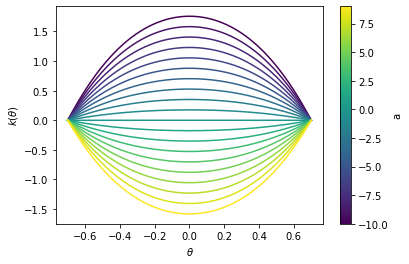

In [47]:
fig, ax = plt.subplots()
ax.set_prop_cycle('color', [mpl.cm.viridis(i) for i in np.linspace(0, 1, a_range.size)])

ax.plot(theta.T, y.T)

fig.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(a_range[0], a_range[-1]), cmap='viridis'), ax=ax, label='a')
ax.set(xlabel=r'$\theta$', ylabel=r'$k(\theta)$')

In the above plot, we see that the amplitude of k seems to be linearly correlated with the value of a (with a minus sign).
We test hypothesis this by plotting two lines but multiplying one of the lines by the ratio of the a values:

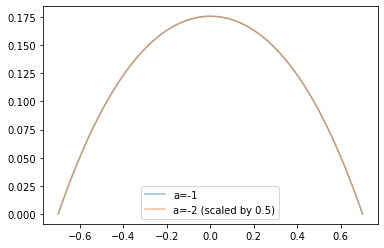

In [48]:
base_i = 9
plt.plot(theta[base_i], y[base_i], alpha=0.5, label=f'a={a_range[base_i]}')
plt.plot(theta[base_i-1], y[base_i-1]*a_range[base_i]/a_range[base_i-1], alpha=0.5,
         label=f'a={a_range[base_i-1]} (scaled by {a_range[base_i]/a_range[base_i-1]})')
plt.legend()

Seems like they overlap almost perfectly. Therefore, we can easily calculate k for any value of a, as long as we have it for one function of k.

# Time-varying boundary angle
We will now simulate how k changes over time, assuming that a is constant for all t. Whether this is a reasonable assumption or not will be investigated.

In [49]:
dalpha = -0.05
alpha_0 = 0.7
time = np.linspace(0, 2, 10)

a = -0.1

thetas = []
ks = []

for t in time:
    bounds = dalpha*t + alpha_0
    # a = 1 / bounds # TODO maybe change a depending on angle
    res = k_bvp(bounds, q, nu, a)
    thetas.append(res.t)
    ks.append(res.y[3])

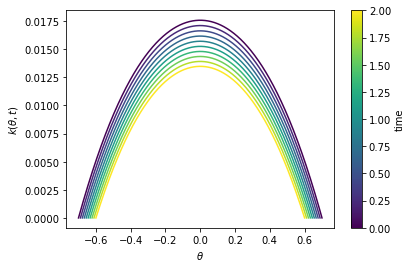

In [50]:
fig, ax = plt.subplots()
ax.set_prop_cycle('color', [mpl.cm.viridis(i) for i in np.linspace(0, 1, time.size)])

for t, theta, k in zip(time, thetas, ks):
    ax.plot(theta, k)

ax.set(ylabel=r'$k(\theta, t)$', xlabel=r'$\theta$')
fig.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(time[0], time[-1]), cmap='viridis'), ax=ax, label='time')

We see that for smaller angles, the maximum of k becomes smaller over time. This may or may not be reasonable. If we expect that the integral of k should remain constant for all times, then we should increase a as the angle decreases, i.e., t increases.

# Calculate $C(\theta)$
Assume that a(t) is 0 at some point in time. Then $k(t)$ should be 0. This gives a way to "easily" calculate $C(\theta)$. Since C is time-independent, this C should be vaild even when a changes value over time.

One of the initial values of C can be calculated from

$-3\dot\alpha = -C'(\alpha/2)\tan\alpha + 2C(\alpha/2)$

$C'(\alpha/2) = \frac{3\dot\alpha + 2C(\alpha/2)}{\tan\alpha}$

which is given from the boundary conditions.

We now try to find the initial condition where C becomes antisymmetric:

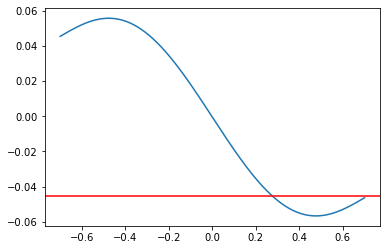

In [191]:
def B(alpha, dalpha):
    """See notes in Onenote for how this is derived."""
    return (-C_alpha - 3*dalpha/2)/np.sin(alpha)


def g(alpha, dalpha, theta, C):
    return B(alpha, dalpha) * np.sin(2*theta) + C

def diff_eq(t, y, q, nu, alpha, dalpha):
    return [y[1],   # f
            y[2],   # df/dtheta
            2*q/nu*y[1]*y[0]-4*y[1],    # ddf/ddtheta
            y[4],   # C
            2/nu*q*y[0]*g(alpha, dalpha, y[3], t)  # dC/dtheta
           ]

q = 1
nu = 1
dalpha = -0.01
alpha_0 = 0.7
# Change this to find a value where C becomes antisymmetric
C_alpha = 0.0455

res = solve_ivp(diff_eq, (-alpha_0, alpha_0), 
                # The first 3 initial conditions are given from shooting from before
                [0, 2.77398676, -1.72584279, C_alpha, (3*dalpha + 2*C_alpha)/np.tan(alpha_0)], 
                args=(q, nu, alpha, dalpha), max_step=0.001)
fig, axes = plt.subplots(ncols=1)
ax = axes
ax.plot(res.t, res.y[3])
ax.axhline(-C_alpha, c='r')

C_numeric = res.y[3]
C_theta = res.t

def C_interp(theta):
    """Get C(theta) for any value of theta within the values where C was numerically calculated.
    C(theta) is calculated using interpolation for numerical calculations.
    """
    return np.interp(theta, C_theta, C_numeric)


# Plot the velocity

In [192]:
def g_interp(theta, t):
    alpha = dalpha*t + alpha_0
    return B(alpha, dalpha) * np.sin(2*theta) + C_interp(theta)


def h_interp(theta, t, dtheta=0.001):
    """h = -dg/dtheta * 1/2
    Can be proven using the fact that the velocity field has 0 divergence.
    """
    return - (g_interp(theta + dtheta, t) - g_interp(theta, t)) / (2*dtheta)

def f_numeric(bound, q, nu):
    """Numerically calculate f.
    Returns theta, f(theta) with theta ranging within -bound, bound.
    """
    res = k_bvp(bound, q, nu, 0)
    return res.t, res.y[0]

In [370]:
theta, f = f_numeric(alpha, q, nu)
r = np.linspace(0.1, 1, 19)[:, np.newaxis]

time = np.linspace(0, 20, 10)
u_theta = np.zeros((time.size, theta.size, r.size)) + 10
u_r = np.zeros((time.size, theta.size, r.size)) + 10

for i, t in enumerate(time):
    u_theta[i, ...] = (g_interp(theta, t) * r).T
    u_r[i, ...] = (-q/r*f + h_interp(theta, t) * r).T

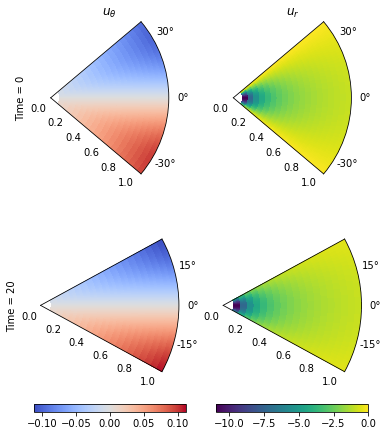

In [390]:
fig, axes = plt.subplot_mosaic([['t0', 'r0'],
                                ['t1', 'r1'],
                                #['ct', 'cr']
                               ]
                              , figsize=(6,8), subplot_kw=dict(projection='polar'))
for ax in axes.values():
    ax.grid(False)


Theta, R = np.meshgrid(theta, r)
t_norm = mpl.colors.Normalize(vmin=u_theta.min(), vmax=u_theta.max())
r_norm = mpl.colors.Normalize(vmin=u_r.min(), vmax=u_r.max())

ax = axes['t0']
ax.pcolormesh(Theta, R, u_theta[0].T, norm=t_norm, cmap='coolwarm')
ax.set_thetalim(theta[0], theta[-1])
ax.set_title(r'$u_\theta$')
ax.set_ylabel(f'Time = {int(time[0])}')

ax = axes['r0']
cm = ax.pcolormesh(Theta, R, u_r[0].T, norm=r_norm, cmap='viridis')
ax.set_thetalim(theta[0], theta[-1])
ax.set_title(f'$u_r$')

ax = axes['t1']
cmt = ax.pcolormesh(Theta, R, u_theta[-1].T, norm=t_norm, cmap='coolwarm')
ax.set_thetalim(-alpha_0 - time[-1]*dalpha, alpha_0 + time[-1]*dalpha)
ax.set_ylabel(f'Time = {int(time[-1])}')

ax = axes['r1']
cmr = ax.pcolormesh(Theta, R, u_r[-1].T, norm=r_norm, cmap='viridis')
ax.set_thetalim(-alpha_0 - time[-1]*dalpha, alpha_0 + time[-1]*dalpha)

fig.colorbar(cmt, ax=axes['t1'], orientation='horizontal')
fig.colorbar(cmr, ax=axes['r1'], orientation='horizontal')
fig.savefig('u.pdf')

Text(0.5, 1.0, 'Time: 20.0')

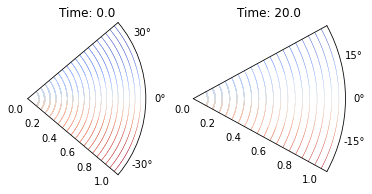

In [364]:
fig, axes = plt.subplots(ncols=2, subplot_kw=dict(projection='polar'))
for ax in axes.flat:
    ax.grid(False)


ax = axes[0]
Theta, R = np.meshgrid(theta, r)
ax.quiver(Theta, R, u_theta[0].T, u_r[0].T, u_theta[0].T, cmap='coolwarm')
ax.set_thetalim(theta[0], theta[-1])
ax.set_title(f'Time: {time[0]}')

ax = axes[1]
ax.quiver(Theta, R, u_theta[-1].T, u_r[-1].T, u_theta[-1].T, cmap='coolwarm')
ax.set_thetalim(theta[0], theta[-1])
ax.set_thetalim(-alpha_0 - time[-1]*dalpha, alpha_0 + time[-1]*dalpha)
ax.set_title(f'Time: {time[-1]}')

# Calculate $k(\theta, t)$

In [ ]:


def dkdt(t, theta, q, nu):
    thetas = np.array([theta-0.001, theta, theta + 0.001])
    -nu/2*np.diff(C_interp(thetas), 2) / np.diff(thetas, 2)

# Calculate $C(\theta)$ from $k(\theta, t)$
$\frac{\partial k}{\partial t} - qf(\theta)g(\theta, t) = -\frac{\nu}{2}\frac{d^2C}{d\theta^2}$

We will now assume a to be constant over time, approximate $\dot k$ using the finite difference method (in this case just a forward Euler) to calculate $C(\theta)$

We do this by first calculating k for many time steps. Then we calculate dkdt from this. Using this, we can calculate $C(\theta)$ using `solve_ivp`.

This code is probably wrong so it should not be used.

In [58]:
from functools import cache


@cache
def get_f(bounds):
    res = k_bvp(bounds, q, nu, 0)
    return res.t, res.y[0]


def dkdt(theta, time):
    # TODO set to zero outside the domain?
    interp_k = [np.interp(theta, angle, k) for k, angle in zip(ks, thetas)]
    dk = np.diff(interp_k) / np.diff(time)
    # Because np.diff returns an array 1 element smaller, we set the derivative of the 1st and 2nd point to be the same.
    return np.r_[dk[0], dk]


def f(theta, alpha):
    f_interp = np.zeros(alpha.shape) - 100
    for i, angle in enumerate(alpha):
        f_theta, f_vals = get_f(angle)
        f_interp[i] = np.interp(theta, f_theta, f_vals)
    return f_interp


def B(alpha, dalpha, C):
    """See notes in Onenote for how this is derived."""
    return (C[0] - 3*dalpha/2)/np.sin(alpha)

def g(alpha, dalpha, theta, C):
    return B(alpha, dalpha, C) * np.sin(2*theta) + C

def ddC(theta, y, time, dalpha, alpha_0, q, nu, a):
    """Differential equation for C(theta). The first half of the return values are dC/dtheta, the second half are C(theta), all for different values of t."""
    alpha = dalpha * time + alpha_0

    return np.r_[y[:len(y)//2],
                 2/nu * (q * g(alpha, dalpha, theta, y[len(y)//2:]) * f(theta, alpha) - dkdt(theta, time) + a)]

res = solve_ivp(ddC, (-alpha_0 - dalpha*time[-1], alpha_0 + dalpha*time[-1]), 
                np.r_[np.ones(time.size), np.zeros(time.size)], args=(time, dalpha, alpha_0, q, nu, a), max_step=0.001)

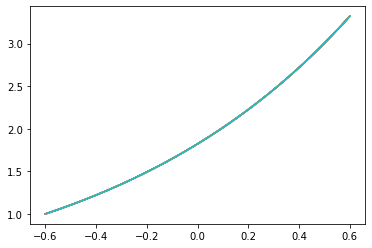

In [59]:
plt.plot(res.t, res.y[:res.y.shape[0]//2].T)

# Old code

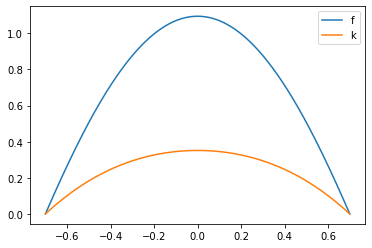

In [72]:
res = solve_ivp(dddf,(-bounds, bounds),[0,r.x[0],r.x[1], 0, r.x[2]],args=(q,nu, a),max_step=0.001)
plt.plot(res.t, res.y[(0, 3), :].T, label=('f', 'k'))
plt.legend()

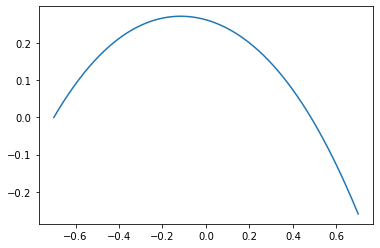

In [70]:
res = solve_ivp(dddf,(-bounds, bounds),[0,2.77,-1.725, 0, 1], args=(q,nu, a),max_step=0.001)
plt.plot(res.t, res.y[3, :].T)

-0.027535317677197503

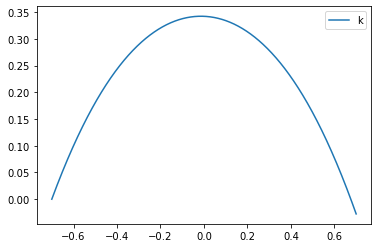

In [17]:
def dddf(t,y,q,nu, a):
    return [y[1],
            y[2],
            2*q/nu*y[1]*y[0]-4*y[1],
            y[4],
            2*q/nu * y[3] * y[0] + a
           ]


def conditions(x,b,q,nu):
    res = solve_ivp(dddf,(-b, b),[0,x[0],x[1]],args=(q,nu),max_step=0.001)
    return [q-np.trapz(res.y[0],res.t),
            res.y[0][-1],
           np.sum(np.interp(np.linspace(-b,0),res.t,res.y[0])
                  -np.interp(np.linspace(0,b),res.t,res.y[0]))]

bounds = 0.7
q = 1
nu = 1
a = -2

res = solve_ivp(dddf,(-bounds, bounds),[0,2.77385398,  -1.72572715, 0, 1.1],args=(q,nu,a),max_step=0.001)
plt.plot(res.t, res.y[3], label='k')
plt.legend()
res.y[3, -1]

In [4]:
def dddf(t,y,q,nu):
    return [y[1],
            y[2],
            2*q/nu*y[1]*y[0]-4*y[1]]


def conditions(x,b,q,nu):
    res = solve_ivp(dddf,(-b, b),[0,x[0],x[1]],args=(q,nu),max_step=0.001)
    return [q-np.trapz(res.y[0],res.t),
            res.y[0][-1],
           np.sum(np.interp(np.linspace(-b,0),res.t,res.y[0])
                  -np.interp(np.linspace(0,b),res.t,res.y[0]))]

bounds=0.7
q = 1
nu = 1
r = root(conditions,[10,-22,0],args=(bounds,q,nu))
print(r)
res = solve_ivp(dddf,(-bounds, bounds),[0,r.x[0],r.x[1]],args=(q,nu),max_step=0.001)
print(1-np.trapz(res.y[0],res.t),np.sum(np.interp(np.linspace(-bounds,0),res.t,res.y[0])-np.interp(np.linspace(0,bounds),res.t,res.y[0])))

    fjac: array([[-5.27206303e-02,  8.49572396e-04, -9.98608939e-01],
       [-8.62644358e-01, -5.03795046e-01,  4.51139000e-02],
       [-5.03055909e-01,  8.63822800e-01,  2.72932712e-02]])
     fun: array([-1.12621024e-12,  2.05187495e-12, -4.85431695e-11])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-2.68021361e-08,  1.13005795e-09, -4.17816095e-10])
       r: array([ 1.22006428e+01,  1.55842581e+01,  8.11981225e-02, -5.56716622e-01,
       -8.19542040e-03,  6.85265646e-03])
  status: 1
 success: True
       x: array([  2.77385398,  -1.72572715, 121.84065961])


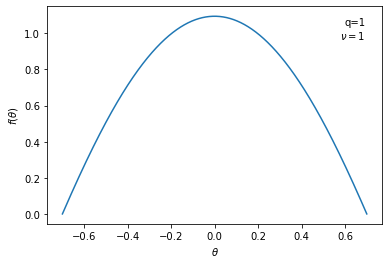

In [10]:
fig, ax = plt.subplots()
ax.plot(res.t,res.y[0])
ax.text(0.95, 0.95, f'{q=}\n' + r'$\nu=1$', ha='right', va='top', transform=ax.transAxes)
ax.set(xlabel=r'$\theta$', ylabel=r'$f(\theta)$')
fig.savefig('f.png')

(array([1.10483662, 2.20851302]), array([[1.54909857e-07, 1.23501652e-07],
       [1.23501652e-07, 4.94241021e-07]]))


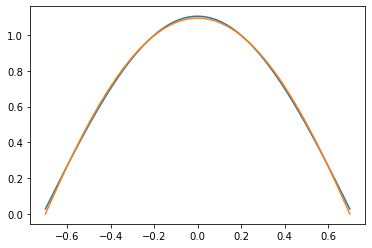

In [9]:
from scipy.optimize import curve_fit

cos = lambda x,a,b: a*np.cos(b*x)
x2 = lambda x,a,b: a*x**2+b
x2_stuck = lambda x,a: a*(x-bounds)*(x+bounds)


fit = curve_fit(cos,res.t,res.y[0])
print(fit)
#plt.plot(res.t,res.y[0]-cos(res.t,*fit[0]))
plt.plot(res.t, cos(res.t, *fit[0]))
plt.plot(res.t, res.y[0])
#plt.plot(res.t,)
#plt.xlim(-0.01,0.01)
#plt.ylim(2.5,2.502)
#plt.xlim(0.29,0.301)
#plt.ylim(0,0.1)

Fel i koden? Borde inte bounds vara en inputparameter till x2_stuck?

In [11]:
bound_check =  np.linspace(0.04,0.71)
fits = []
for b in bound_check:
    r = root(conditions,[10,-22,0],args=(b,q,nu))
    res = solve_ivp(dddf,(-b, b),[0,r.x[0],r.x[1]],args=(q,nu),max_step=0.001)
    fits.append(curve_fit(x2_stuck,res.t,res.y[0]))

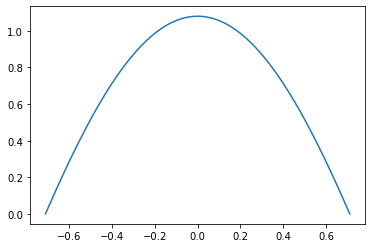

In [17]:
plt.plot(res.t, res.y[0])
plt.plot(res.t, x2_stuck(res.t, fits[-1]))

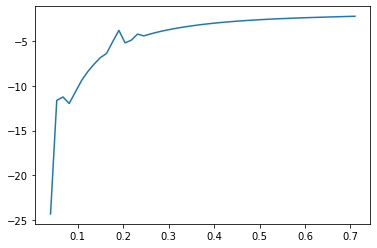

In [12]:
plt.plot(bound_check,[i[0][0] for i in fits])
plt.show()
#plt.plot(bound_check,[i[0][1] for i in fits])

Text(0, 0.5, 'error')

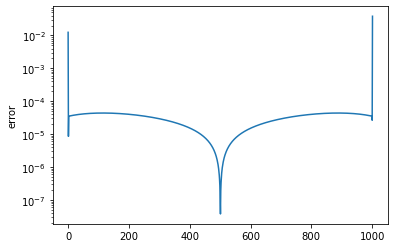

In [107]:
#Check that integral is correct

plt.semilogy(np.abs(np.gradient(res.y[2],res.t) - (2*res.y[0]-4)*res.y[1]))

plt.ylabel("error")

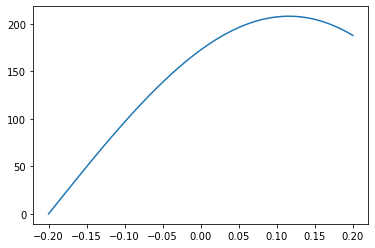

In [72]:
res = solve_ivp(dddf,(-0.2, 0.2),[0,-10,1000],args=(1,1),max_step=0.01)
plt.plot(res.t,res.y[0])
#np.sum(np.interp(np.linspace(-0.2,0),res.t,res.y[0])-np.interp(np.linspace(0,0.2),res.t,res.y[0]))

1.0681498135873182 2.3576214419439827


0.7853981633974483

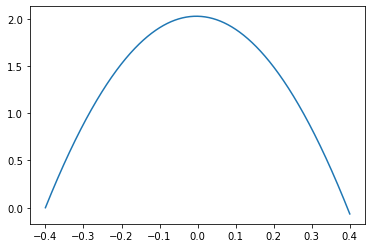

In [271]:
res = solve_ivp(dddf,(-0.40, 0.40),[0,10,-22],args=(1,1),max_step=0.001)
plt.plot(res.t,res.y[0])
print(np.trapz(res.y[0],res.t),np.sum(np.interp(np.linspace(-bounds,0),res.t,res.y[0])-np.interp(np.linspace(0,bounds),res.t,res.y[0])))
np.pi/4